# MLSS 2019: Optimal Transport and Wasserstein Distances

The goal of this first practical session is to introduce computational optimal transport (OT) in Python. You will familiarize yourself with OT by:
1. using the Python library POT (Python Optimal Transport),
2. coding Sinkhorn's algorithm.

In the second practical session, we will use optimal transport as a nice geometrical tool in machine learning.

<b>We are going to use Google Collab to run this notebook. In order to install all the necessary files run the following cells:</b>

In [1]:
import os
!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=optimal_transport_tutorial

  Cloning https://github.com/mlss-skoltech/tutorials.git to /tmp/pip-req-build-s1h6nkuj
  Running command git clone --filter=blob:none --quiet https://github.com/mlss-skoltech/tutorials.git /tmp/pip-req-build-s1h6nkuj
  Resolved https://github.com/mlss-skoltech/tutorials.git to commit e23a317eb748102712b8c16452b696d37a1ac065
  Preparing metadata (setup.py) ... done
  Created wheel for optimaltransport: filename=optimaltransport-0.1-py3-none-any.whl size=1191 sha256=091d4abb2621e7a47c5f48bd7ad622294707237075019cf5a1df8ba17ac8510d
  Stored in directory: /tmp/pip-ephem-wheel-cache-wssvuf_2/wheels/2d/ee/70/46ab0430decb3bf01257f0e6166b8b17dd4edaa1aa3c43223f
Successfully built optimaltransport


In [2]:
# Check your installation by importing POT
!pip install pot
import ot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.0/790.0 kB 14.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


<b>If you are running this notebook locally, make sure to clone the tutorial repository:</b>

```!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=optimal_transport_tutorial```



And install the following package:

* Install with pip: ```bash pip install pot```
* Install with conda: ```bash conda install -c conda-forge pot ```

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Solving Exact OT: Linear Programming

### Reminders on Optimal Transport

Optimal Transport is a theory that allows us to compare two (weighted) points clouds $(X, a)$ and $(Y, b)$, where $X \in \mathbb{R}^{n \times d}$ and $Y \in \mathbb{R}^{m \times d}$ are the locations of the $n$ (resp. $m$) points in dimension $d$, and $a \in \mathbb{R}^n$, $b \in \mathbb{R}^m$ are the weights. We ask that the total weights sum to one, i.e. $\sum_{i=1}^n a_i = \sum_{j=1}^m b_j = 1$.

The basic idea of Optimal Transport is to "transport" the mass located at points $X$ to the mass located at points $Y$.

Let us denote by $\mathcal{U}(a,b) = \left\{ P \in \mathbb{R}^{n \times m} \,|\, P \geq 0, \sum_{j=1}^m P_{ij} = a_i, \sum_{i=1}^n P_{ij} = b_j\right\}$ the set of admissible transport plans.

If $P \in \mathcal{U}(a,b)$, the quantity $P_{ij} \geq 0$ should be regarded as the mass transported from point $X_i$ to point $Y_j$. For this reason, it is called a *transport plan*.

We will also consider a *cost matrix* $C \in \mathbb{R}^{n \times m}$. The quantity $C_{ij}$ should be regarded as the cost paid for transporting one unit of mass from $X_i$ to $Y_j$. This cost is usually computed using the positions $X_i$ and $Y_j$, for example $C_{ij} = \|X_i - Y_j\|$ or $C_{ij} = \|X_i - Y_j\|^2$.

Then transporting mass according to $P \in \mathcal{U}(a,b)$ has a total cost of $\sum_{ij} P_{ij} C_{ij}$.

In "Optimal Transport", there is the word _Optimal_. Indeed, we want to find a transport plan $P \in \mathcal{U}(a,b)$ that will minimize its total cost. In other words, we want to solve
$$
    \min_{P \in \mathcal{U}(a,b)} \sum_{ij} C_{ij }P_{ij}.
$$

This problem is a Linear Program: the objective function is linear in the variable $P$, and the constraints are linear in $P$. We can thus solve this problem using classical Linear Programming algorithms, such as the simplex algorithm.

If $P^*$ is a solution to the Optimal Transport problem, we will say that $P^*$ is an optimal transport plan between $(X, a)$ and $(Y, b)$, and that $\sum_{ij} P^*_{ij} C_{ij}$ is the optimal transport distance between $(X, a)$ and $(Y, b)$: it is the minimal amount of "energy" that is necessary to transport the initial mass located at points $X$ to the target mass located at points $Y$.

### Computing Optimal "Croissant" Transport using POT

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in Moscow.

We use fictional positions, production and sale numbers (that both sum to the same value).

We have acess to the position of Bakeries $X \in \mathbb{R}^{8 \times 2}$ and their respective production $a \in \mathbb{R}^8$ which describe the source point cloud. The Cafés where the croissants are sold are defined by their position $Y \in \mathbb{R}^{5 \times 2}$ and $b \in \mathbb{R}^{5}$.

In [4]:
# Load the data
import pickle

with open('croissants.pickle', 'rb') as file:
    croissants = pickle.load(file)

X = croissants['bakery_pos']
a = croissants['bakery_prod']
Y = croissants['cafe_pos']
b = croissants['cafe_prod']

print('Bakery productions =', a)
print('Café sales =', b)
print('Total number of croissants =', a.sum())

Bakery productions = [31. 48. 82. 30. 40. 48. 89. 73.]
Café sales = [82. 88. 92. 88. 91.]
Total number of croissants = 441.0


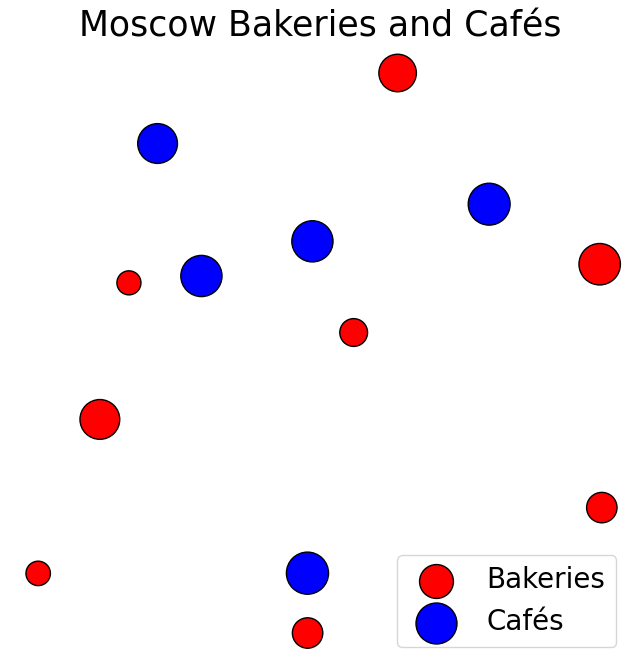

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], s=10*a, c='r', edgecolors='k', label='Bakeries')
plt.scatter(Y[:,0], Y[:,1], s=10*b, c='b', edgecolors='k', label='Cafés')
plt.legend(fontsize=20)
plt.axis('off')
plt.title('Moscow Bakeries and Cafés', fontsize=25)
plt.show()

Let us now compute the cost matrix $C \in \mathbb{R}^{n \times m}$. Here, we will use two different costs: $\ell_1$ and $\ell_2$ costs.

In [8]:
C_1 = np.zeros((8,5))
C_2 = np.zeros((8,5))
for i in range(8):
    for j in range(5):
        C_1[i,j] = np.linalg.norm(X[i]-Y[j]) # TODO: contains the l1 distances
        C_2[i,j] = C_1[i,j]**2  # TODO: contains the squared of l2 distances

We can now compute the Optimal Transport plan to transport the croissants from the bakeries to the cafés, for the two different costs.

In [9]:
optimal_plan_1 = ot.emd(a, b, C_1) # TODO: compute the exact OT plan using function ot.emd
print(optimal_plan_1)
optimal_cost_1 = np.sum(optimal_plan_1*C_1) # TODO: compute the OT cost for the l1 ground cost
print('1-Wasserstein distance =', optimal_cost_1)
print('')

optimal_plan_2 = ot.emd(a, b, C_2) # TODO: compute the exact OT plan using function ot.emd
print(optimal_plan_2)
optimal_cost_2 = np.sum(optimal_plan_2*C_2) # TODO: compute the OT cost for squared of the l2 ground cost
print('2-Wasserstein distance =', np.sqrt(optimal_cost_2))

[[ 0. 31.  0.  0.  0.]
 [ 0.  0. 48.  0.  0.]
 [25. 57.  0.  0.  0.]
 [30.  0.  0.  0.  0.]
 [ 0.  0.  0. 40.  0.]
 [ 0.  0. 44.  2.  2.]
 [ 0.  0.  0.  0. 89.]
 [27.  0.  0. 46.  0.]]
1-Wasserstein distance = 61523.15971278249

[[ 0. 31.  0.  0.  0.]
 [ 0.  0. 48.  0.  0.]
 [52. 30.  0.  0.  0.]
 [30.  0.  0.  0.  0.]
 [ 0. 27.  0. 13.  0.]
 [ 0.  0. 44.  2.  2.]
 [ 0.  0.  0.  0. 89.]
 [ 0.  0.  0. 73.  0.]]
2-Wasserstein distance = 3292.139032582319


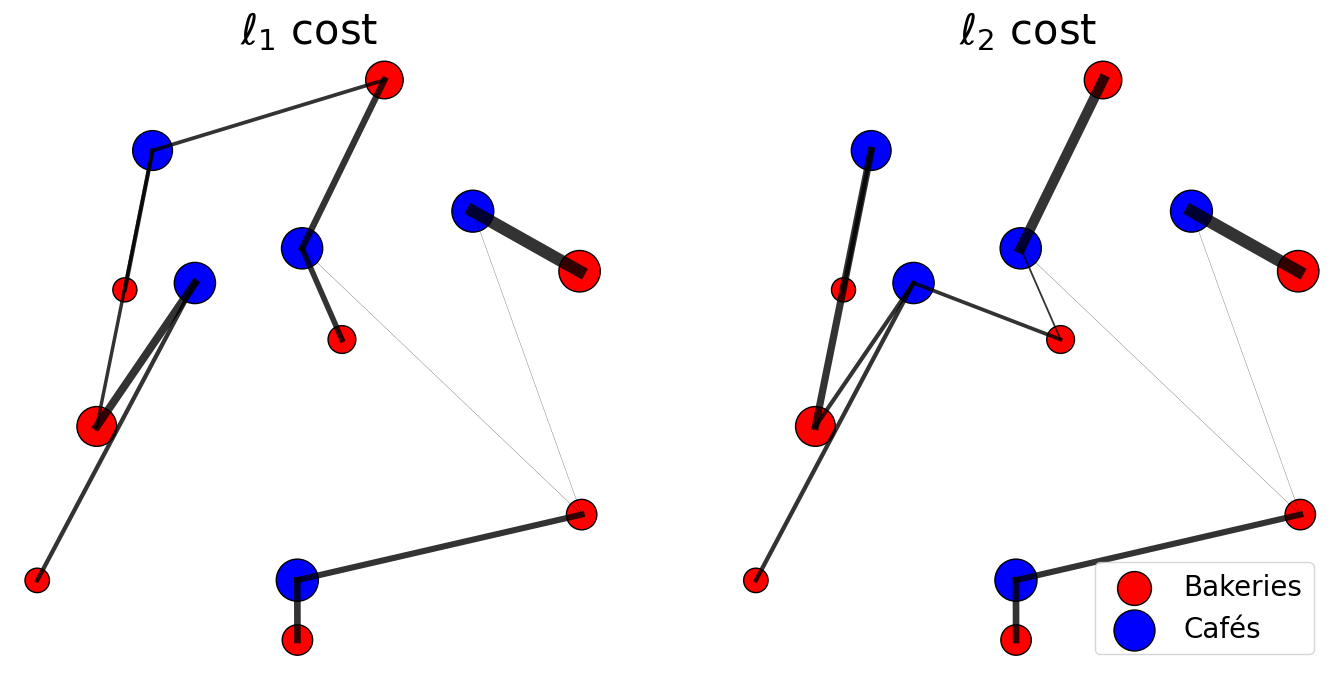

In [25]:
fig = plt.figure(figsize=(17,8))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], s=10*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=10*b, c='b', edgecolors='k', label='Cafés')
# TODO: plot a line between Bakery i and Café j whenever some croissants are transported between i and j
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=0.1*optimal_plan_1[i,j], alpha=0.8)
ax.axis('off')
ax.set_title('$\ell_1$ cost', fontsize=30)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X[:,0], X[:,1], s=10*a, c='r', edgecolors='k', label='Bakeries')
ax.scatter(Y[:,0], Y[:,1], s=10*b, c='b', edgecolors='k', label='Cafés')
# TODO: plot a line between Bakery i and Café j whenever some croissants are transported between i and j
for i in range(8):
    for j in range(5):
        ax.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], c='k', lw=0.1*optimal_plan_2[i,j], alpha=0.8)
ax.axis('off')
ax.set_title('$\ell_2$ cost', fontsize=30)

plt.legend(fontsize=20)
plt.show()

## 2. Sinkhorn Algorithm for Entropy Regularized Optimal Transport

### Reminders on Sinkhorn Algorithm

In real applications, and especially in Machine Learning, we often have to deal with huge numbers of points. In this case, the linear programming algorithms which have cubic complexity will take too much time to run.

That's why in practise, among other reasons, people minimize another criterion given by
$$
    \min_{P \in \mathcal{U}(a,b)} \langle C, P \rangle + \gamma \sum_{ij} P_{ij} [ \log(P_{ij}) - 1].
$$
When $\gamma$ is sufficiently small, we can consider that a solution to the above problem (often refered to as "Entropy-regularized Optimal Transport") is a good approximation of a real optimal transport plan.

In order to solve this problem, one can remark that the optimality conditions imply that a solution $P_\gamma^*$ necessarily is of the form $P_\gamma^* = \text{diag}(u) \, K \, \text{diag}(v)$, where $K = \exp(-C/\gamma)$ and $u,v$ are two non-negative vectors.

$P_\gamma^*$ should verify the constraints, i.e. $P_\gamma^* \in \mathcal{U}(a,b)$, so that
$$
    P_\gamma^* 1_m = a \text{  and  } (P_\gamma^*)^T 1_n = b
$$
which can be rewritten as
$$
    u \odot (Kv) = a \text{  and  } v \odot (K^T u) = b
$$

Then Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$
    u \leftarrow \frac{a}{Kv} \text{  and  } v \leftarrow \frac{b}{K^T u}
$$

In [20]:
def sinkhorn(a, b, C, epsilon=0.1, max_iters=100):
    """Run Sinnkhorn's algorithm"""

    # TODO: Compute the kernel matrix K
    K = np.exp(-C/epsilon)
    # TODO: Alternate projections
    v = np.ones(b.shape[0])
    for _ in range(max_iters):
      u = a/K.dot(v)
      v = b/K.T.dot(u)

    return np.diag(u).dot(K).dot(np.diag(v)) # TODO

In [21]:
np.round(sinkhorn(a, b, C_2/C_2.max(), epsilon=0.01), 2)

array([[ 1.75, 29.67,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , 47.29,  0.  ,  0.  ],
       [48.9 , 34.25,  0.  ,  0.  ,  0.  ],
       [29.93,  0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.09, 23.37,  1.5 , 15.54,  0.  ],
       [ 0.  ,  0.  , 43.21,  0.  ,  4.05],
       [ 0.  ,  0.  ,  0.  ,  0.  , 86.95],
       [ 1.33,  0.2 ,  0.  , 72.46,  0.  ]])

In [14]:
optimal_plan_2

array([[ 0., 31.,  0.,  0.,  0.],
       [ 0.,  0., 48.,  0.,  0.],
       [52., 30.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.],
       [ 0., 27.,  0., 13.,  0.],
       [ 0.,  0., 44.,  2.,  2.],
       [ 0.,  0.,  0.,  0., 89.],
       [ 0.,  0.,  0., 73.,  0.]])

We first show that this algorithm is consistent with classical optimal transport, using the "croissant" transport example.

In [34]:
plan_diff = []
distance_diff = []
for epsilon in np.linspace(0.01, 1, 100):
    optimal_plan_sinkhorn = sinkhorn(a, b, C_2/C_2.max(), epsilon)  # TODO: compute OT plan using Sinkhorn, with regularization strength epsilon
    optimal_cost_sinkhorn = np.sum(optimal_plan_sinkhorn*C_2) # TODO: compute OT distance using Sinkhorn
    plan_diff.append(np.linalg.norm(optimal_plan_sinkhorn - optimal_plan_2)/a.sum()) # TODO: compute the Frobenius distance between the exact OT plan and the Sinkhorn OT plan
    distance_diff.append(np.abs(optimal_cost_sinkhorn - optimal_cost_2)/optimal_cost_2) # TODO: compute the error between exact OT and Sinkhorn values (in %)

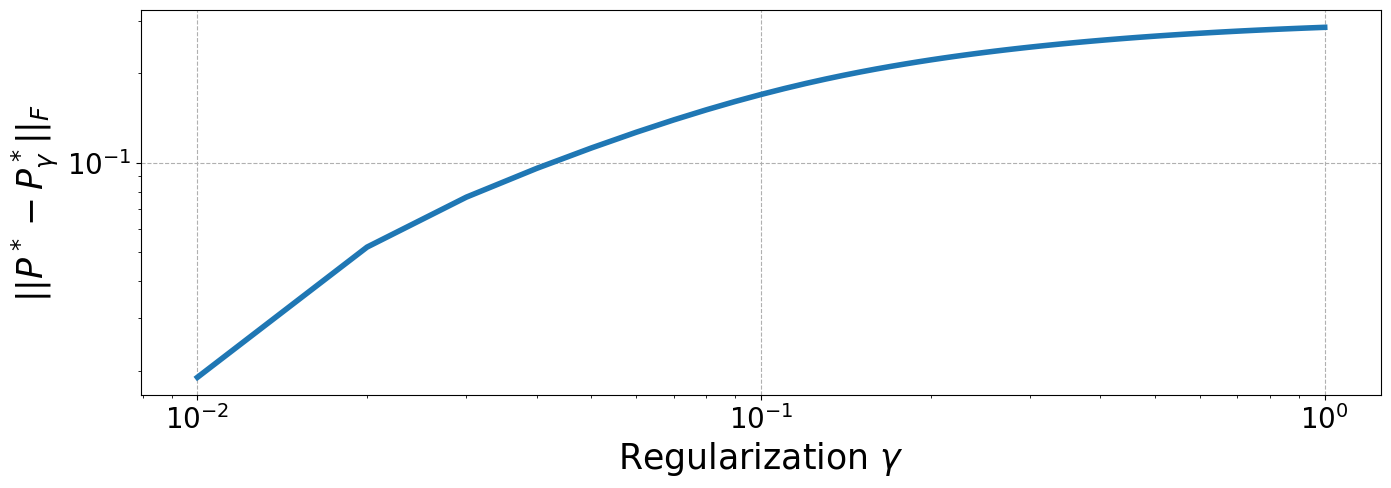

In [32]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), plan_diff, lw=4)
plt.xlabel('Regularization $\gamma$', fontsize=25)
plt.ylabel('$||P^* - P_\gamma^*||_F$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()

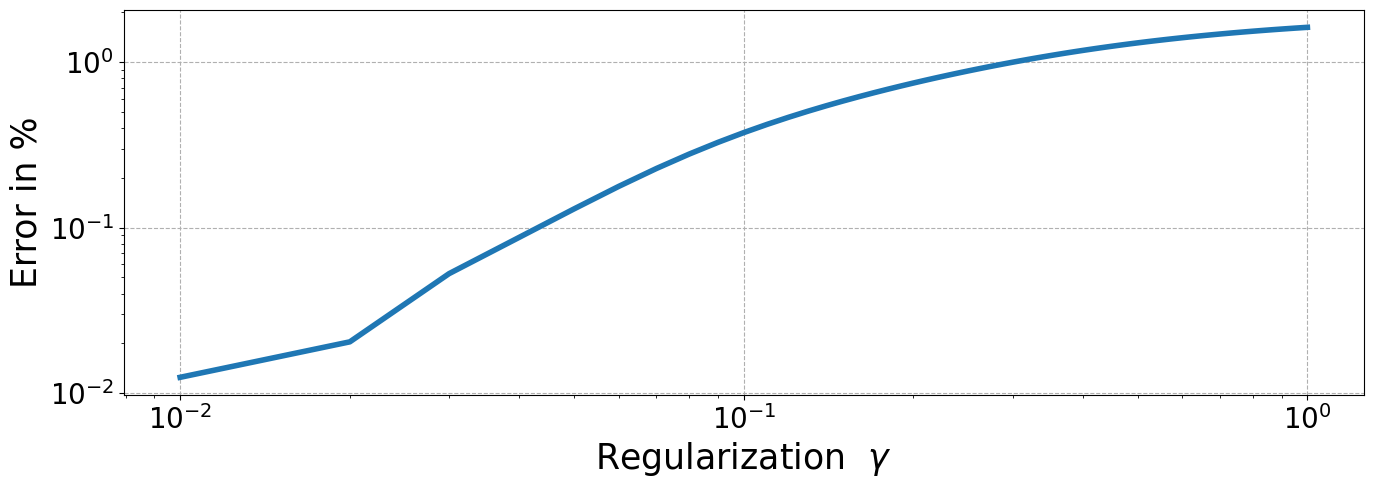

In [36]:
plt.figure(figsize=(16,5))
plt.loglog(np.linspace(0.01, 1, 100), distance_diff, lw=4)
plt.xlabel('Regularization  $\gamma$', fontsize=25)
plt.ylabel('Error in %', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--')
plt.show()